![](img/572_banner.png)
%%HTML
<script src="require.js"></script>

# Advanced Deep Learning

**Mahmood Amintoosi, Spring 2024**

I should mention that the original material was from [Tomas Beuzen's course](https://ubc-mds.github.io/DSCI_572_sup-learn-2).

![](img/force.png)

## Lecture Outline
<hr>

<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-Learning-Objectives" data-toc-modified-id="Lecture-Learning-Objectives-2">Lecture Learning Objectives</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li><li><span><a href="#1.-Autoencoders" data-toc-modified-id="1.-Autoencoders-4">1. Autoencoders</a></span></li><li><span><a href="#2.-Generative-Adversarial-Networks-(GANs)" data-toc-modified-id="2.-Generative-Adversarial-Networks-(GANs)-5">2. Generative Adversarial Networks (GANs)</a></span></li><li><span><a href="#3.-Multi-input-Networks" data-toc-modified-id="3.-Multi-input-Networks-6">3. Multi-input Networks</a></span></li><li><span><a href="#4.-Things-I-Haven't-Talked-About" data-toc-modified-id="4.-Things-I-Haven't-Talked-About-7">4. Things I Haven't Talked About</a></span></li><li><span><a href="#5.-Tom's-Cheat-Sheet" data-toc-modified-id="5.-Tom's-Cheat-Sheet-8">5. Tom's Cheat Sheet</a></span></li><li><span><a href="#6.-The-Lecture-in-Three-Conjectures" data-toc-modified-id="6.-The-Lecture-in-Three-Conjectures-9">6. The Lecture in Three Conjectures</a></span></li></ul></div>

## Lecture Learning Objectives
<hr>

- Describe what an autoencoder is at a high level and what they can be useful for
- Describe what a generative adversarial network is at a high level and what they can be useful for
- Describe what a multi-input model is and what they can be useful for

## Imports
<hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, utils, models
from torchsummary import summary
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from utils.plotting import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import json
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})
import plotly.io as pio
pio.renderers.default = 'notebook'

## 1. Autoencoders
<hr>

- Autoencoders (AE) are networks that are designed to reproduce their input at the output layer
- They are composed of an "encoder" and "decoder"
- The hidden layers of the AE are typically smaller than the input layers, such that the dimensionality of the data is reduced as it is passed through the encoder, and then expanded again in the decoder:

![](img/autoencoder.png)

- Why would you want to use such a model? As you can see, AEs perform dimensionality reduction by learning to represent your input features using fewer dimensions
- That can be useful for a range of tasks but we'll look at some specific examples below

### 1.1. Example 1: Dimensionality Reduction

- Here's some synthetic data of 3 features and two classes
- Can we reduce the dimensionality of this data to two features while preserving the class separation?

In [4]:
n_samples = 500
X, y = make_blobs(n_samples, n_features=2, centers=2, cluster_std=1, random_state=123)
X = np.concatenate((X, np.random.random((n_samples, 1))), axis=1)
X = StandardScaler().fit_transform(X)
plot_scatter3D(X, y)

- We can see that `X1` and `X2` split the data nicely, and the `X3` is just noise
- The question is, can an AE learn that this data can be nicely separated in just two of the three dimensions?
- Let's build a simple AE with the following neurons in each layer: 3 -> 2 -> 3:

In [5]:
class autoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
BATCH_SIZE = 100
torch.manual_seed(1)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataloader = DataLoader(X_tensor,
                        batch_size=BATCH_SIZE)
model = autoencoder(3, 2)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sigmoid()
  )
)


In [7]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for batch in dataloader:
        optimizer.zero_grad()           # Clear gradients w.r.t. parameters
        y_hat = model(batch)            # Forward pass to get output
        loss = criterion(y_hat, batch)  # Calculate loss
        loss.backward()                 # Getting gradients w.r.t. parameters
        optimizer.step()                # Update parameters

- We only care about the encoder now, does it represent our data nicely in reduced dimensions?

In [8]:
model.eval()
print(f"Original X shape = {X_tensor.shape}")
X_encoded = model.encoder(X_tensor)
print(f" Encoded X shape = {X_encoded.shape}")

Original X shape = torch.Size([500, 3])
 Encoded X shape = torch.Size([500, 2])


In [9]:
plot_scatter2D(X_encoded, y)

- What did we just do? We used an AE to effectively reduce the number of features in our data
- This is very similar to concepts of unsupervised learning and clustering that you'll discuss in DSCI 563.

### 1.2. Example 2: Image Denoising

- Okay, let's do something more interesting
- We saw above that AEs can be useful feature reducers (i.e., they can remove unimportant features from our data)
- This also applies to images and it's a fun application to de-noise images!
- Take a look at these images of 8's from the MNIST dataset, I'm going to mess them up by adding some noise to them:

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:10<00:00, 945kB/s] 


Extracting ../../data/MNIST\raw\train-images-idx3-ubyte.gz to ../../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]


Extracting ../../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]


Extracting ../../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


Extracting ../../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/MNIST\raw



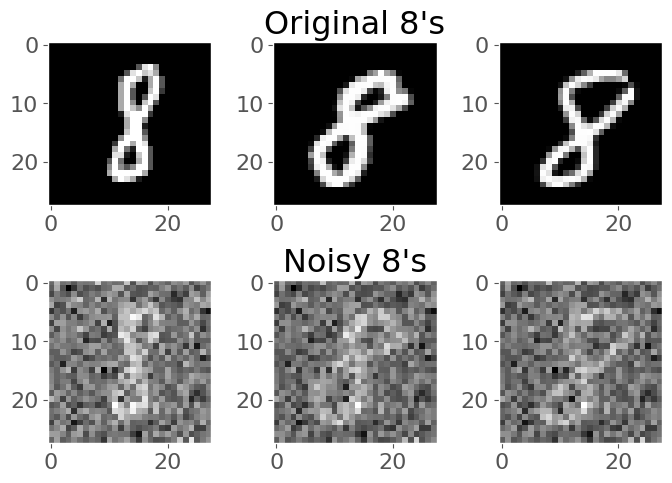

In [8]:
BATCH_SIZE = 32

# Download data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('../../data/', download=True, train=True, transform=transform)
idx = trainset.targets == 8  # let's only work with the number 8
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Sample plot
X, y = next(iter(trainloader))
noise = 0.5
plot_eights(X, noise)

- Can we train an AE to get rid of that noise and reconstruct the original 8's? Let's give it a try!
- I'm going to use convolutional layers in my AE now as we are dealing with images
- We'll use `Conv2D()` layers to *compress* our images into a reduced dimensonality, and then we need to "upsample" it back to the original size
- One ingredient you'll need to know to do this is "transposed convolutional layers". These are just like "convolutional layers" but for the purpose of "upsampling" (increasing the size of) our data. Rather than simply expanding the size of our data and interpolating, we use 
`nn.ConvTranspose2d()` layers to help us learn how to best upsample our data:

![](img/conv_trans_1.gif)

![](img/conv_trans_2.gif)

Source: modified from [A guide to convolution arithmetic for deep learning, Vincent Dumoulin (2018)](https://arxiv.org/abs/1603.07285)

See [Transposed Convolution](appendixH_transposed_conv.ipynb) in appendices.

In [9]:
def conv_block(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)  # reduce x-y dims by two; window and stride of 2
    )

def deconv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2),
        nn.ReLU()
    )

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 16),
            conv_block(16, 8)
        )
        self.decoder = nn.Sequential(
            deconv_block(8, 8, 3),
            deconv_block(8, 16, 2),
            deconv_block(16, 32, 2),
            nn.Conv2d(32, 1, 3, padding=1)  # final conv layer to decrease channel back to 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # get pixels between 0 and 1
        return x

- So we want to train our model to remove that noise I added
- Generally speaking, the idea is that the model learns what pixel values are important, we are reducing the dimensionality of the imaages, so our model must learn only the crucial information (i.e., not the noise) needed to reproduce the image
- Right now, our model probably produces gibberish because it isn't trained:

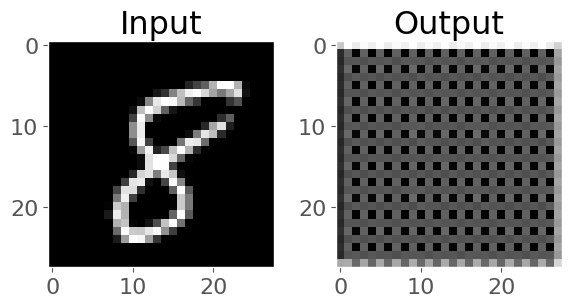

In [10]:
model = autoencoder()
input_8 = X[:1, :1, :, :]
output_8 = model(input_8)
plot_eight_pair(input_8, output_8)

- How do we train it?
- Well we feed in a noisy image, compare it to the non-noisy version, and let the network learn how to make that happen
- We want the value of the predicted pixels to be as close as possible to the real pixel values, so we'll use `MSELoss()` as our loss function:

In [11]:
%%time
EPOCHS = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
img_list = []

for epoch in range(EPOCHS):
    losses = 0
    for batch, _ in trainloader:
        noisy_batch = batch + noise * torch.randn(*batch.shape)
        noisy_batch = torch.clip(noisy_batch, 0.0, 1.0)
        optimizer.zero_grad()
        y_hat = model(noisy_batch)
        loss = criterion(y_hat, batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"epoch: {epoch + 1}, loss: {losses / len(trainloader):.4f}")
    # Save example results each epoch so we can see what's going on
    with torch.no_grad():
        noisy_8 = noisy_batch[:1, :1, :, :]
        model_8 = model(input_8)
        real_8 = batch[:1, :1, :, :]
    img_list.append(utils.make_grid([noisy_8[0], model_8[0], real_8[0]], padding=1))

epoch: 1, loss: 0.1079
epoch: 2, loss: 0.0576
epoch: 3, loss: 0.0477
epoch: 4, loss: 0.0444
epoch: 5, loss: 0.0422
epoch: 6, loss: 0.0406
epoch: 7, loss: 0.0393
epoch: 8, loss: 0.0382
epoch: 9, loss: 0.0371
epoch: 10, loss: 0.0362
epoch: 11, loss: 0.0355
epoch: 12, loss: 0.0348
epoch: 13, loss: 0.0341
epoch: 14, loss: 0.0336
epoch: 15, loss: 0.0332
epoch: 16, loss: 0.0326
epoch: 17, loss: 0.0324
epoch: 18, loss: 0.0320
epoch: 19, loss: 0.0317
epoch: 20, loss: 0.0315
CPU times: total: 7min 47s
Wall time: 2min 33s


In [12]:
%%capture
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title("Input        Prediction        Actual")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani.save('eights.gif', writer='imagemagick', fps=2)
# HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

![](img/eights.gif)

- Pretty cool!

## 2. Generative Adversarial Networks (GANs)
<hr>

### 2.1. What are GANs?

- [GANs](https://arxiv.org/abs/1406.2661) were invented in 2014 by Ian Goodfellow and colleagues
- GANs are pretty complex but they are just so cool so I wanted to talk about them briefly
- The goal of a GAN is to develop a model that can generate realistic "fake" data, like the face below
>If you look closely, you'll notice that some things don't look quite right, like the glasses...

![](img/fake-face.jpeg)

- GANs are mostly used to generate imagery at the moment so I'll speak about them in that context
- The "adversarial" comes from the fact that we actually have two networks "battling" each other:
    1. The "Generator": takes some noise (like Gaussian noise) as input and generates "fake" data (like an image)
    2. The "Discriminator": takes in real and fake data from the generator and attempts to classify it as "real" or "fake"

![](img/gan.png)

- An analogy always helps
- Think of the "Generator" as a new counterfeit artist trying to produce realistic-looking famous artworks to sell

![](img/art.png)

- The "Discriminator" is an art-critic, trying to determine if a piece of art is "real" or "fake"
- At first, the "Generator" produces poor art-replicas which the "Discriminator" can easily tell are fake

![](img/fake.png)

- But over time, the "Generator" learns ways to produce art that fools the "Discriminator"
- Eventually, the "Generator" gets so good, that the "Discriminator" can't tell if a piece of art is real or fake - the "Generator" is now able to generate realistic fake artwork! Money, money, money!

![](img/art-2.png)

- GANs are mostly used to generate imagery at the moment so I'll focus on that
- Training a GAN really happens in two iterative phases:
    1. **Train the Discriminator:**
        - Generate some fake images with the generator
        - Show the discriminator real images and fake images and get it to classify them correctly (a simple binary classification problem)
    2. **Train the Generator:**
        - Generate fake images with the generator but label them as "real"
        - At first, the discriminator will easily identify the "fake" images as "fake" (it's already been trained a little bit to do this)
        - This means the generator will have a large loss (the discriminator predicted the images as "fake" but the label is "real")
        - We use this loss to update the generator's weights. Next time around, the loss will be less, because the generator will produce some images that the discriminator thinks are real.
    3. **Repeat!**

### Additional Resources:

* [Generative Adversarial Networks (Persian)](https://howsam.org/generative-adversarial-network/)

* [How to Develop a 1D Generative Adversarial Network From Scratch in Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/)
    - **Colab** [GAN-01](https://colab.research.google.com/github/fum-cs/dl-fall-2023/blob/main/code/GAN/GAN-01.ipynb), Exercise: Convert TF2PyTorch

Enough talk, let's code it up!

### 2.2. An Example: Generating Bitmojis

- I'm going to use our favourite bitmoji dataset to try and develop a GAN (this may or may not go well):

In [ ]:
# Training Parameters
IMAGE_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE = 100
NUM_EPOCHS = 200  # we often need a lot of epochs to train GANs
LR = 0.0008

IMAGE_DIR = "data/bitmoji_rgb/train/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
# Loader
bitmoji_dataset = datasets.ImageFolder(root=IMAGE_DIR, transform=data_transforms)
bitmoji_loader = torch.utils.data.DataLoader(bitmoji_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using device: cuda


- I'm going to base my architecture off the one in the original [Deep Convolutional (DCGAN) paper](https://arxiv.org/pdf/1511.06434.pdf)
- Here's the generator (the disciminator is the inverse of this):

![](img/dcgan-generator.png)

- This is pretty complex stuff, but amazingly, we know what all of this is going to mean
- Let's create the "Generator" first:

In [22]:
def convtrans_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Generator(nn.Module):
    def __init__(self, LATENT_SIZE):
        super().__init__()
        self.main = nn.Sequential(
            convtrans_block(LATENT_SIZE, 512, 4, stride=1, padding=0),
            convtrans_block(512, 256, 4, stride=2, padding=1),
            convtrans_block(256, 128, 4, stride=2, padding=1),
            convtrans_block(128, 64, 4, stride=2, padding=1),
            convtrans_block(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

- We should be able to pass some noise to our generator and it will spit out an image (probably not a good one yet, as we haven't trained!):

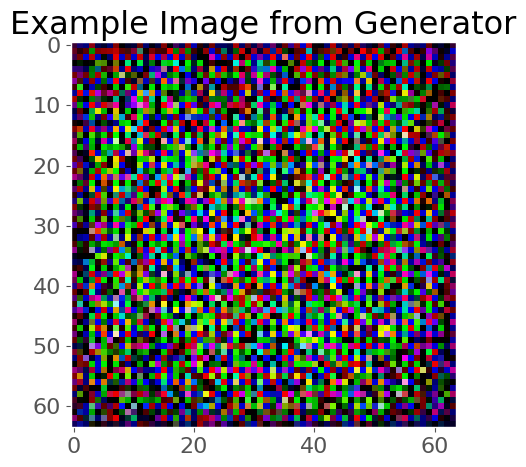

In [23]:
generator = Generator(LATENT_SIZE)
example_noise = torch.randn(1, LATENT_SIZE, 1, 1)
fake = generator(example_noise).squeeze().detach()
plt.figure(figsize=(5, 5))
plt.title("Example Image from Generator")
plt.imshow(np.transpose(fake, (1, 2, 0)));

- Create discriminator

In [24]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, True)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            conv_block(64, 128, 4, 2, 1),
            conv_block(128, 256, 4, 2, 1),
            conv_block(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

- Let's make sure our discriminator is able to make a prediction:

In [25]:
discriminator = Discriminator()
fake = generator(example_noise)
discriminator(fake).item()

0.48948991298675537

- Okay, we're almost ready to train, the DCGAN paper recommends initializing the GAN with values from a normal distribution
- I'll talk more about this later, for now, I'm just going to run this function:

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator = Generator(LATENT_SIZE)
generator.apply(weights_init)
generator.to(device)
discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

- Okay, we're ready to train
- Our loss functions will be `BCEWithLogitsLoss()` - remember, the discriminator is just a binary classification network
- However, because we train the generator and discriminator separately, we'll need two optimizers:

In [27]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)  # Fixed noise vector we'll use to track image generation evolution

- I've meticulously commented each line in the following training loop, hopefully it's not too hard to follow!

In [28]:
%%time
# Lists to keep track of progress
img_list = []
gen_losses = []
dis_losses = []
ITERS = 0

print("Begin training...")
for epoch in range(NUM_EPOCHS):
    
    for real_batch, _ in bitmoji_loader:

        ### STEP 1: train discriminator
        # Train with real data
        discriminator.zero_grad()
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float, device=device)  # Real labels
        output = discriminator(real_batch).view(-1)  # Forward pass real batch through discriminator
        loss_real = criterion(output, real_labels)   # Calculate discriminator loss on real batch
        loss_real.backward()                         # Calculate gradients for discriminator with backward pass
        D_real = output.mean().item()                # Avg. D output on real batch
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1, device=device)  # Generate some noise to feed to generator
        fake_batch = generator(noise)                                      # Generate fake images with generator using the noise vector
        fake_labels = torch.zeros_like(real_labels)           # Fake labels
        output = discriminator(fake_batch.detach()).view(-1)  # Forward pass fake batch through discriminator (detach the generator though! we don't want to backprop through it)
        loss_fake = criterion(output, fake_labels)            # Calculate discriminator loss on real batch
        loss_fake.backward()                                  # Calculate gradients for discriminator with backward pass
        D_fake = output.mean().item()                         # Avg. D output on fake batch
        
        # Update discriminator weights and store loss
        optimizerD.step()
        loss_dis = loss_real + loss_fake
        
        ### STEP 2: train generator
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)           # Forward pass fake batch through updated discriminator
        loss_gen = criterion(output, real_labels)             # Calculate generator loss on fake batch
        loss_gen.backward()                                   # Calculate gradients for generator with backward pass
        
        # Update generator weights and store loss
        optimizerG.step()
        
        # Metadata
        gen_losses.append(loss_gen.item())
        dis_losses.append(loss_dis.item())
        
        if ITERS % 50 == 0:
            print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})",
                  f"Iteration ({ITERS + 1})",
                  f"Loss_G: {loss_gen.item():.4f}",
                  f"Loss_D: {loss_dis.item():.4f}",
                  f"D_real: {D_real:.4f}",  # this should start around 1 and go down to 0.5 over time
                  f"D_fake: {D_fake:.4f}")  # this should start around 0 and go up to 0.5 over time

        ITERS += 1
    
    ### Store loss and track image evolution
    if epoch % 2 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, nrow=4, normalize=True))
        
        
print("Finished training!")

Begin training...
Epoch (1/200) Iteration (1) Loss_G: 14.9377 Loss_D: 1.9841 D_real: 0.4098 D_fake: 0.5358
Epoch (2/200) Iteration (51) Loss_G: 38.9919 Loss_D: 0.0000 D_real: 1.0000 D_fake: 0.0000
Epoch (4/200) Iteration (101) Loss_G: 38.1705 Loss_D: 0.0000 D_real: 1.0000 D_fake: 0.0000
Epoch (6/200) Iteration (151) Loss_G: 0.0000 Loss_D: 100.0002 D_real: 0.9998 D_fake: 1.0000
Epoch (8/200) Iteration (201) Loss_G: 5.3094 Loss_D: 8.3992 D_real: 0.0282 D_fake: 0.0029
Epoch (10/200) Iteration (251) Loss_G: 4.0712 Loss_D: 0.2853 D_real: 0.8592 D_fake: 0.1106
Epoch (12/200) Iteration (301) Loss_G: 3.6460 Loss_D: 1.3744 D_real: 0.9850 D_fake: 0.5297
Epoch (13/200) Iteration (351) Loss_G: 3.9092 Loss_D: 0.1415 D_real: 0.9454 D_fake: 0.0783
Epoch (15/200) Iteration (401) Loss_G: 4.7152 Loss_D: 0.2218 D_real: 0.9721 D_fake: 0.1580
Epoch (17/200) Iteration (451) Loss_G: 0.9062 Loss_D: 0.8309 D_real: 0.5063 D_fake: 0.0222
Epoch (19/200) Iteration (501) Loss_G: 5.2779 Loss_D: 0.4013 D_real: 0.9171

```C
Begin training...
Epoch (1/200) Iteration (1) Loss_G: 1.7893 Loss_D: 3.2550 D_real: 0.2664 D_fake: 0.3662
Epoch (2/200) Iteration (51) Loss_G: 3.4757 Loss_D: 0.8228 D_real: 0.8536 D_fake: 0.2715
Epoch (3/200) Iteration (101) Loss_G: 4.5845 Loss_D: 0.5271 D_real: 0.8543 D_fake: 0.1388
Epoch (5/200) Iteration (151) Loss_G: 5.2458 Loss_D: 0.2388 D_real: 0.9584 D_fake: 0.1332
...
...
Epoch (199/200) Iteration (5351) Loss_G: 7.4502 Loss_D: 0.0076 D_real: 0.9979 D_fake: 0.0053
Finished training!
CPU times: total: 9min 33s
Wall time: 10min 34s
```

- Now, here's a fancy animation that shows how our generator got better over time
- I could have trained for longer, but the results are pretty cool!

In [29]:
%%capture
fig = plt.figure(figsize=(6,6))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani.save('bitmoji.gif', writer='imagemagick', fps=2)
# HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

![](img/bitmoji-gan.gif)

* Amintoosi {cite}`ST_for_DA_2022` utilized style transfer techniques for data augmentation in fire detection. To fully understand this paper, it is important to be familiar with Generative Adversarial Networks (GANs), [Conditional GANs](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/), Cycle GANs, image-to-image translation, Neural Style Transfer (NST), and StyleGANs.

Excersice:

* [Understand and run this NST repo](https://github.com/eriklindernoren/Fast-Neural-Style-Transfer)

**Further Reading**

* NST papers:
    - [Gatys Image Style Transfer: Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
    - [Evaluation in Neural Style Transfer: A Review (2024)](https://arxiv.org/pdf/2401.17109)

* [Section 12.4 of Deep Learning with Python: Variational Autoencoders](https://fumdrive.um.ac.ir/index.php/s/tbdbtwzCkqbMoGD)
    - **Colab** [Variational autoencoders](https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part04_variational-autoencoders.ipynb)

* [Section 12.4 of Deep Learning with Python: Generative adversarial networks](https://fumdrive.um.ac.ir/index.php/s/tbdbtwzCkqbMoGD)
    - **Colab** [Generative adversarial networks](https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part05_gans.ipynb)

* [GFPGAN aims at developing a Practical Algorithm for Real-world Face Restoration](https://github.com/TencentARC/GFPGAN)
    - **Colab** [GFPGAN_inference](https://colab.research.google.com/github/fum-cs/dl-fall-2023/blob/main/code/GAN/GFPGAN_inference.ipynb)

* StyleGAN: A Style-Based Generator Architecture for Generative Adversarial Networks [Wiki](https://en.wikipedia.org/wiki/StyleGAN)
    - [StyleGAN - Official TensorFlow Implementation](https://github.com/NVlabs/stylegan)
    - [A Gentle Introduction to StyleGAN the Style Generative Adversarial Network](https://machinelearningmastery.com/introduction-to-style-generative-adversarial-network-stylegan/)
    - [Video](https://www.aparat.com/v/t240q17)

* [GAN Zoo: A list of all named GANs](https://github.com/hindupuravinash/the-gan-zoo)

* [GAN applications](https://github.com/nashory/gans-awesome-applications)

* [GAN tutorial on Medium](https://github.com/mpstewart1/GAN-Tutorial)

* [Deep Convolutional Generative Adversarial Networks](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html)

* [Generative Adversarial Networks (d2l)](https://d2l.ai/chapter_generative-adversarial-networks/index.html)



## 3. Multi-input Networks
<hr>

- Sometimes you'll want to combine different types of data in a single network
- The most common case is combining tabular data with image data, for example, using both real estate data and images of a house to predict its sale price:

![](img/multi-input.png)

Source: "[House](https://www.flickr.com/photos/68089229@N06/17458373552)" by [oatsy40](https://www.flickr.com/photos/68089229@N06), "[House in Vancouver](https://www.flickr.com/photos/17573364@N00/433449690)" by [pnwra](https://www.flickr.com/photos/17573364@N00), "[House](https://www.flickr.com/photos/21098413@N04/5405425139)" by [noona11](https://www.flickr.com/photos/21098413@N04) all licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/?ref=ccsearch&atype=rich).

- In such a problem you may want to combine:
    1. a NN for the tabular data
    2. a CNN for the image data
- The way we often do this is create these two models, and then combine them together into a model that produces a single output
- This sounds complicated but it's pretty easy! We only need one new ingredient which is a concatenation function: `torch.cat()`
- Below is a simple example:

In [33]:
class MultiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 8, 5, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1800, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )
        
        self.multi = nn.Sequential(
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
    def forward(self, image, data):
        x_cnn = self.cnn(image)
        x_fc = self.fc(data)
        x_multi = torch.cat((x_cnn, x_fc), dim=1)
        return self.multi(x_multi)

In [34]:
model = MultiModel()
image = torch.randn(1, 3, 64, 64)
data = torch.randn(1, 10)
model(image, data).item()

-0.40757834911346436

- The above network doesn't really do anything but show that we can easily combine a CNN and fully connected NN!

## 4. Things I Haven't Talked About
<hr>

- Recurrent neural networks (coming in DSCI 575 and DSCI 574, good for sequential data like text and time series)
- Bayesian neural networks (in one sentence: capture uncertainty by learning a distribution over the network parameters rather than learning point estimates)
- Training at scale/distributed computing (coming in DSCI 525)
- Working with other forms of data like time series (DSCI 574), text (DSCI 575), audio, video, etc.
- [Pruning](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) (removing unnecessary weights from a deep network) and [quantization](https://pytorch.org/docs/stable/quantization.html) (use a small data type for model weights and operations, e.g., integers rather than floats) to reduce memory foot print and increase speed
- High-level PyTorch APIs: [Ignite](https://github.com/pytorch/ignite), [Skorch](https://github.com/skorch-dev/skorch), [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning), etc.
- Adversarial examples. In one sentence: this is about "tricking" a model by adding some artifact, like noise, to the input image. See this [OpenAI blog post](https://openai.com/blog/adversarial-example-research/) or some work on [adversarial stickers](https://arxiv.org/pdf/1904.00759.pdf) (more comining in DSCI 541)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


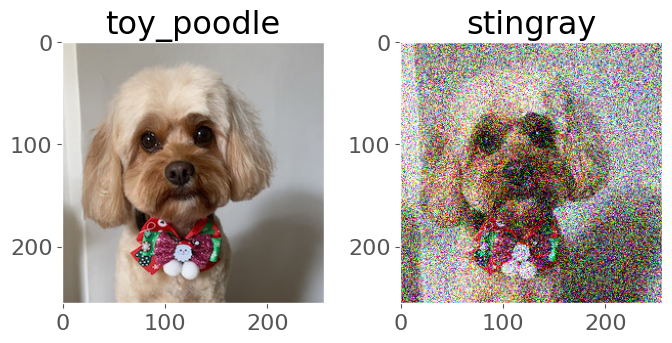

In [ ]:
densenet = models.densenet121(pretrained=True)
densenet.eval()
classes = json.load(open("data/imagenet_class_index.json"))
idx2label = [classes[str(k)][1] for k in range(len(classes))]
torch.manual_seed(0)
image = Image.open('img/evie.png')
image = transforms.functional.to_tensor(image).unsqueeze(0)
image_noise = image + 0.30 * torch.randn_like(image)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
_, image_noise_idx = torch.softmax(densenet(image_noise), dim=1).topk(1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
ax1.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
ax1.set_title(f"{idx2label[image_idx.item()]}")
ax2.imshow(np.transpose(image_noise.squeeze(), (1, 2, 0)))
ax2.set_title(f"{idx2label[image_noise_idx.item()]}")
plt.tight_layout()

- Weight initiailization in layers:
    - We explored how the starting point of your optimization can affect the final result
    - The general rule for setting the weights in a neural network is to set them to be close to zero without being too small
    - PyTorch does this for you automatically, but if you want to make your code exactly reproducible and be in control of the initialization, you can do that too
    - It's easy to do in PyTorch using the `.apply()` method:

```python
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)
```

In [38]:
class example(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 3, (3, 3)),
            nn.Flatten(),
            nn.Linear(2028, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [39]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

torch.manual_seed(123)
model = example()
model.apply(weights_init);

Initializing weights of a Conv2d layer!
Initializing weights of a Linear layer!
Initializing weights of a Linear layer!


## 5. Tom's Cheat Sheet
<hr>

**TABULAR DATA**
- Classification:
    1. Logisitic Regression + feature engineer
    2. XGBoost / LGBM + feature engineer
    3. Neural network + feature engineer
- Regression:
    1. Linear Regression + feature engineer
    2. XGBoost / LGBM + feature engineer
    3. Neural network + feature engineer

**IMAGE DATA**
- Use a CNN:
    - Option 1: if data is relatively simple, develop CNN from scratch:
        - Start with 3x3 filters with strides of 1 or 2
        - Number of filters proprtional to data complexity, usually 4, 8, 16, 24
        - The first convolutional layer should have more channels that the input data
    - Option 2: transfer learning
    
**TIME SERIES DATA**
1. AutoRegressive Integrated Moving Average (ARIMA) - more in 574
2. XGBoost / LGBM + feature engineer
3. Recurrent neural network (RNN) - more in 575/574

**AUDIO, VIDEO, OTHER**
- Probably some kind of NN

## References

```{bibliography}
:style: alpha
```

## 6. The Lecture in Three Conjectures
<hr>

1. There is a world of deep learning out there. You now have the foundational skills to explore that world!
2. I personally feel that PyTorch is an amazing tool for deep learning and I hope that you'll continue to use it in your future data science careers.
3. There is no magic bullet for solving data science problems. But, you don't need to do things from scratch! Do your research, look at how others have approached a similar problem to yours, and leverage the work that's already out there. 

![](img/mission.png)